# 1.0 Imports

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import numpy as np
import cv2
from tqdm import tqdm
import itertools
from time import time
import torch
import supervision as sv
from depthAnythingModel.depth_anything_v2.dpt import DepthAnythingV2
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from Utils.ObjectDetection import ObjectDetectionUtils
from Utils.EstimateHeight import EstimateHeight
from collections import defaultdict, deque
from Gui.CameraCalibrateApp import CameraCalibrateApp
from Utils.DataProcessor import DataProcessor

xFormers not available
xFormers not available


In [2]:
VIDEO_PATH = 'walking4.mp4'

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU.


# 2.0 load the models

## 2.1 object Detection Model

In [4]:
# Build a YOLOv9c model from pretrained weight
yolo_model = YOLO("pretrained_weights/yolov9c-seg.pt")
tracker = sv.ByteTrack()

yolo_model.to(device)

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
           

In [5]:
MyDetector =  ObjectDetectionUtils(yolo_model)

## 2.2 Depth estimation model

In [6]:
def load_depth_model(device, encoder='vitl', load_from='pretrained_weights/depth_anything_v2_metric_vkitti_vitl.pth', max_depth=25):
    
    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
    
    depth_anything = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
    depth_anything.load_state_dict(torch.load(load_from, map_location=device))
    depth_anything = depth_anything.to(device).eval()
    
    return depth_anything

In [7]:
depth_anything= load_depth_model(device)

## 2.3 Automatic Camera Calibration Model

In [8]:
class AutomaticCalibrationModel(nn.Module):
    def __init__(self):
        super(AutomaticCalibrationModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc21 = nn.Linear(128, 260)
        self.fc22 = nn.Linear(260, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc21(x))
        x = torch.relu(self.fc22(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))  
        return x

def custom_loss(y_pred, y_true):
    epsilon = 1e-8  # Small constant to prevent log(0)
    y_pred = torch.clamp(y_pred, min=epsilon)  # Clipping predictions to avoid log(0)
    y_true = torch.clamp(y_true, min=epsilon)
    l = torch.mean((torch.log(y_pred) - torch.log(y_true))**2)
    return l

In [9]:
# Initialize the model, loss function, and optimizer
cam_clib_model = AutomaticCalibrationModel().to(device)
optimizer = optim.Adam(cam_clib_model.parameters(), lr=0.001)

# 3.0 Select the ground truth heights on the first frame

In [10]:
app = CameraCalibrateApp(VIDEO_PATH)
ground_truth_lines, frame = app.start()

print(f'You have drawn {len(ground_truth_lines)} lines.')

depth_map = depth_anything.infer_image(frame)

You have drawn 2 lines.


plotting the depth map for visualization

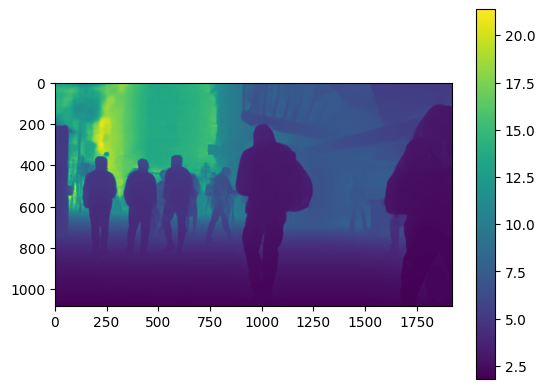

In [11]:
# Assuming depth_map is your NumPy array of size (w, h)
plt.imshow(depth_map, cmap='viridis')
plt.colorbar()
plt.show()


In [12]:
anchor_lines = []

for start_loaction, end_location, true_length in ground_truth_lines:
    length_pixels = np.sqrt((end_location[0] - start_loaction[0]) ** 2 + (end_location[1] - start_loaction[1]) ** 2)
    middle_point = ((start_loaction[0] + end_location[0]) // 2, (start_loaction[1] + end_location[1]) // 2)

    depth = depth_map[middle_point[1], middle_point[0]]

    
    anchor_lines.append((length_pixels,  true_length,  depth))

anchor_lines


[(487.03695958315114, 175.0, 4.351649), (276.2607463973121, 160.0, 7.009362)]

# 4.0 Data Generation for the automatic camera calibration model

## 4.1 collect data from tracking

In [13]:
cap = cv2.VideoCapture(VIDEO_PATH)

number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

tracking_data = {}
frame_count = -1

step = 5  # sample each 5 frames
frames_limit = min (1000, number_of_frames)

# Initialize tqdm progress bar
pbar = tqdm(total=frames_limit, desc="Data Genartion in progress")

while cap.isOpened():
    ret, frame = cap.read()
    frame_count += 1
    if not ret:
        break

    if frame_count % step != 0:
        continue

    results, legs_and_heads, boxes = MyDetector.infer_obj_detection(frame)

    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)
    depth_map = depth_anything.infer_image(frame)


    for detection_idx, _ in enumerate(detections):
        xyxy = detections[detection_idx].xyxy.tolist()[0]
        obj_id = detections[detection_idx].tracker_id[0]

        best_idx = MyDetector.match_best_box(xyxy, boxes)

        head_pos, leg_pos = legs_and_heads[best_idx]

        start, end = head_pos, leg_pos
        length_pixels = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        middle_point = ((start[0] + end[0]) // 2, (start[1] + end[1]) // 2)

        depth = depth_map[middle_point[1], middle_point[0]]

        if obj_id not in tracking_data:
            tracking_data[obj_id] = [(depth, length_pixels)]
        else:
            tracking_data[obj_id].append((depth, length_pixels))

    # Update progress bar
    pbar.update(step)

    cv2.waitKey(1)

    if frame_count >= frames_limit:
        break

pbar.close()
cap.release()
cv2.destroyAllWindows()

Data Genartion in progress: 1005it [02:42,  6.19it/s]                          


In [15]:
tracking_data

{1: [(4.3363624, 483.8109134775693),
  (4.288134, 468.2574078431648),
  (4.6285863, 440.50085130451225),
  (4.650639, 428.2627698037736),
  (4.629539, 427.51842065576545),
  (4.7669263, 412.0436870041816),
  (5.0756135, 391.0818328687744),
  (4.987567, 395.0113922407808),
  (4.951779, 384.2551235832777),
  (5.157715, 383.1761996784247),
  (5.4015737, 372.29289544658246),
  (5.3865976, 355.0),
  (5.439351, 353.0693982774491),
  (5.569971, 341.2477106150311),
  (5.538653, 343.0131192826303),
  (5.6381755, 341.4103103305464),
  (5.8793564, 335.65756359718756),
  (5.986437, 324.5566206380637),
  (5.9634895, 316.07752213657966),
  (5.979585, 300.1666203960727),
  (6.336312, 296.2043213729334),
  (6.278807, 302.026488904533),
  (6.293177, 299.0),
  (6.256668, 289.4995682207488),
  (6.3809085, 281.40007107319644),
  (6.5547743, 277.72108310317384),
  (6.540873, 270.0296280040396),
  (6.6442204, 259.0077218926108),
  (6.5461745, 264.09278672466615),
  (6.7820992, 247.58432906789557),
  (7.1153

## 4.2 preparing the dataset for the DL model

In [16]:
X, y = DataProcessor.generate_and_prepare_tensors(tracking_data, device)

print(X.shape)

torch.Size([116410, 2])


In [18]:
# Create a dataset and split into training and test sets
full_dataset = TensorDataset(X, y)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training the model

In [19]:
num_epochs = 3
for epoch in range(num_epochs):
    cam_clib_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = cam_clib_model(X_batch)
        loss = custom_loss(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cam_clib_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/3, Loss: 0.20537173748016357
Epoch 2/3, Loss: 0.036056339740753174
Epoch 3/3, Loss: 0.02756095677614212


Testing the model

In [20]:
# Evaluate the model
cam_clib_model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = cam_clib_model(X_batch)
        loss = custom_loss(y_pred, y_batch)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

Test Loss: 0.04375203974048638


Infer fuction 

In [21]:
def infer_cam_calib(cam_clib_model, current_depth, depth_diff):
    current_depth = float(current_depth)
    depth_diff = float(depth_diff)
    scale_change = cam_clib_model(torch.tensor([current_depth, depth_diff], dtype=torch.float32 , device=device )  )
    return scale_change.item()
print (infer_cam_calib(cam_clib_model, 4, 5))
print (infer_cam_calib(cam_clib_model, 4, -2))

0.41123151779174805
1.832153558731079


It make sense if we are at depth 4 meter fr

# 5.0 Estimating heights from the Video

In [22]:
def detect_head_and_leg(video_path, output_video_path, tracker, depth_anything, anchors):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Couldn't open video.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_count = 0
    object_heights = defaultdict(lambda: deque(maxlen=40))  # Store height measurements for each object

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results, legs_and_heads, boxes = MyDetector.infer_obj_detection(frame)

        detections = sv.Detections.from_ultralytics(results)
        detections = tracker.update_with_detections(detections)

        depth_map = depth_anything.infer_image(frame)

        for detection_idx, _ in enumerate(detections):
            xyxy = detections[detection_idx].xyxy.tolist()[0]
            obj_id = detections[detection_idx].tracker_id[0]

            best_idx = MyDetector.match_best_box(xyxy, boxes)
            head_pos, leg_pos = legs_and_heads[best_idx]

            # Calculate pixel distance and depth
            start, end = head_pos, leg_pos
            length_pixels = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            middle_point = ((start[0] + end[0]) // 2, (start[1] + end[1]) // 2)
            depth = depth_map[middle_point[1], middle_point[0]]

            # Estimate height
            height = EstimateHeight.estimate_height_currnetFrame(length_pixels, depth, anchors, infer_cam_calib, cam_clib_model)
            
            # Use the new function to estimate and smooth the height
            stable_height = EstimateHeight.get_stable_height(object_heights, obj_id, height)

            frame = EstimateHeight.annotate_frame(frame, head_pos, leg_pos, stable_height)

        # Display the frame
        cv2.imshow('Frame', frame)

        # Write the frame into the output video file
        out.write(frame)

        # Exit if 'Esc' key is pressed
        if cv2.waitKey(1) & 0xFF == 27:  # 27 is the Esc key
            break

        frame_count += 1
        print(f"Processed frame {frame_count}/{total_frames}")

    # Release everything when finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage
output_video_path = 'output_video.mp4'
detect_head_and_leg(VIDEO_PATH, output_video_path, tracker, depth_anything, anchor_lines)


Processed frame 1/3493
Processed frame 2/3493
Processed frame 3/3493
Processed frame 4/3493
Processed frame 5/3493
Processed frame 6/3493
Processed frame 7/3493
Processed frame 8/3493
Processed frame 9/3493
Processed frame 10/3493
Processed frame 11/3493
Processed frame 12/3493
Processed frame 13/3493
Processed frame 14/3493
Processed frame 15/3493
Processed frame 16/3493
Processed frame 17/3493
Processed frame 18/3493
Processed frame 19/3493
Processed frame 20/3493
Processed frame 21/3493
Processed frame 22/3493
Processed frame 23/3493
Processed frame 24/3493
Processed frame 25/3493
Processed frame 26/3493
Processed frame 27/3493
Processed frame 28/3493
Processed frame 29/3493
Processed frame 30/3493
Processed frame 31/3493
Processed frame 32/3493
Processed frame 33/3493
Processed frame 34/3493
Processed frame 35/3493
Processed frame 36/3493
Processed frame 37/3493
Processed frame 38/3493
Processed frame 39/3493
Processed frame 40/3493
Processed frame 41/3493
Processed frame 42/3493
P